## Community Health Equity Lab: New York COVID19 Response Analysis

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 300
pd.set_option('display.max_rows', 500)

## Data

Data comes from the 2018 NY Census

The Definitive Healthcare Hospital Bed DB

Google Location Mobility Report (Feb 15 - Apr 11)

In [3]:
#reading zip code data and joining borough name
ny = pd.read_csv('data/ny18_cleaned.csv')
ny.head()

,GEOID_ZIP,ALAND10,AWATER10,tot_pop,white,per_white,black,per_black,native,per_native,asian,per_asian,nativehawaiian,per_hawaiian,other,per_other,two_or_mor,per_two_or,male,female,under_5,per_under_5,5_to_9,per_5_to_9,10_to_14,per_10_to_14,15_to_19,per_15_to_19,20_to_24,per_20_to_24,25_to_29,per_25_to_29,30_to_34,per_30_to_34,35_to_39,per_35_to_39,40_to_44,per_40_to_44,45_to_49,per_45_to_49,50_to_54,per_50_to_54,55_to_59,per_55_to_59,60_to_64,per_60_to_64,65_to_69,per_65_to_69,70_to_74,per_70_to_74,75_to_79,per_75_to_79,80_to_84,per_80_to_89,80_and_over,per_80_and_over,disabled,per_disabled,unemployment_rate,tot_households_snap,households_snap,per_households_snap,tot_pop_mobility,same_house,moved_within_1yr,less_10k,10k_15k,15k_25k,25k_35k,35k_50k,50k_75k,75k_100k,100k_150k,150k_200k,more_200k,med_income,mean_incom,speaks_only_english,naturalized,non_citizen,pop_pov,pop_below_,pcnt_pov,families_on_suplimental_income,families_on_social_security,2_ppl_fam,3_to_4_ppl,5_to_6_ppl,GT_7_ppl_f,insured,per_insured,uninsured,per_uninsured,owner,rent,4_16_2020_positive,4_16_2020_tests,4_16_2020_positive_rate,4_2_2020_positive,4_2_2020_tests,4_2_2020_positive_rate,4_3_2020_positive,4_3_2020_tests,4_3_2020_positive_rate,4_7_2020_positive,4_7_2020_tests,4_7_2020_positive_rate,4_8_2020_positive,4_8_2020_tests,4_8_2020_positive_rate,hospital_count,3_26_bb_beds,4_2_bb_beds,4_7_bb_beds,licensed_beds,staffed_beds,ICU_beds,adult_icu_beds,pediatrics_icu_beds,bed_utilization_rate,potential_increase_bed_capacity,avg_ventilator_use
0,10065,984654,0,28109,24285,86.4,619,2.2,37,0.1,2666,9.5,0,0.0,154,0.5,348,1.2,12248,15861,1650,5.9,1000,3.6,916,3.3,356,1.3,1785,6.4,2671,9.5,3176,11.3,2558,9.1,1607,5.7,1570,5.6,1796,6.4,1460,5.2,1522,5.4,1388,4.9,1486,5.3,1159,4.1,954,3.4,1055,3.8,1894,6.8,70.2,14844,414,2.8,27635,22612,2247,5.0,2.7,4.0,2.7,6.2,10.6,8.8,14.4,9.8,35.8,127375,242978,19681,3045,3306,27963,1922,3.0,109,1683,3797,2267,275,13,27299,97.3,744,2.7,5365,9479,233,682,34.16,121,385,0.314286,121,385,0.314286,171,492,34.76,187,544,34.38,14,7625,7993,7993,6493,5519,745,745,402,6.647990,974,181
1,10069,249050,0,5085,3155,62.0,148,2.9,0,0.0,1558,30.6,0,0.0,0,0.0,224,4.4,2354,2731,368,7.2,416,8.2,274,5.4,95,1.9,235,4.6,427,8.4,594,11.7,639,12.6,508,10.0,374,7.4,378,7.4,235,4.6,197,3.9,61,1.2,87,1.7,109,2.1,0,0.0,88,1.7,182,3.6,74.7,2552,73,2.9,5025,3790,859,8.7,3.2,0.0,9.8,5.7,4.2,14.7,11.4,11.6,30.9,110625,225183,2922,331,1207,5085,522,7.3,25,88,517,662,27,0,4992,98.2,93,1.8,675,1877,40,105,38.10,24,57,0.421053,24,57,0.421053,29,72,40.28,32,81,39.51,9,4922,4922,4922,4093,3765,410,410,273,4.741397,328,138
2,10075,477137,0,21556,18396,85.3,677,3.1,225,1.0,1047,4.9,0,0.0,902,4.2,309,1.4,10096,11460,1041,4.8,1252,5.8,736,3.4,763,3.5,778,3.6,1400,6.5,2022,9.4,1643,7.6,1148,5.3,1453,6.7,1244,5.8,1118,5.2,1131,5.2,1561,7.2,1276,5.9,1169,5.4,570,2.6,1251,5.8,1689,8.0,68.1,11035,217,2.0,21381,18455,1508,1.9,0.8,4.8,6.4,5.0,12.8,10.6,17.9,9.6,30.3,137146,233358,13727,3315,2372,21155,1075,4.5,129,1401,3133,1765,236,0,20715,97.9,440,2.1,4933,6102,294,631,46.59,160,371,0.431267,160,371,0.431267,204,452,45.13,232,501,46.31,15,7573,7729,7729,6277,5678,788,788,412,7.253486,599,198
3,10128,1206191,0,59256,47167,79.6,2182,3.7,0,0.0,5844,9.9,0,0.0,1666,2.8,2397,4.0,25338,33918,3204,5.4,2138,3.6,1911,3.2,1691,2.9,2644,4.5,6825,11.5,7216,12.2,4349,7.3,3849,6.5,4103,6.9,3845,6.5,2989,5.0,3494,5.9,3461,5.8,2656,4.5,1980,3.3,1557,2.6,1344,2.3,4825,8.1,72.2,30691,1506,4.9,58419,48263,4921,4.5,2.2,6.5,3.6,5.6,12.4,11.2,14.6,10.0,29.4,114010,196844,39143,7054,6535,58980,3686,3.4,500,3513,8171,5192,530,3,57424,96.9,1820,3.1,10129,20562,460,1207,38.11,212,596,0.355705,212,596,0.355705,281,737,38.13,317,834,38.01,13,5936,6233,6233,4713,4177,514,514,337,6.464822,536,147
4,10280,297253,38409,9384,7360,78.4,184,2.0,0,0.0,1474,15.7,0,0.0,77,0.8,289,3.1,4477,4907,711,7.6,628,6.7,454,4.8,192,2.0,239,2.5,523,5.6,1374,14.6,945,10.1,1021,10.9,771,8.2,763,8.1,530,5.6,375,4.0,370,3.9,254,2.7,

In [4]:
boroughs_zip = pd.read_csv('data/bor_zip_codes.csv')
ny = pd.merge(ny,boroughs_zip[['GEOID10', 'borough']], left_on='GEOID_ZIP', right_on='GEOID10')
del(boroughs_zip)
ny.head()

,GEOID_ZIP,ALAND10,AWATER10,tot_pop,white,per_white,black,per_black,native,per_native,asian,per_asian,nativehawaiian,per_hawaiian,other,per_other,two_or_mor,per_two_or,male,female,under_5,per_under_5,5_to_9,per_5_to_9,10_to_14,per_10_to_14,15_to_19,per_15_to_19,20_to_24,per_20_to_24,25_to_29,per_25_to_29,30_to_34,per_30_to_34,35_to_39,per_35_to_39,40_to_44,per_40_to_44,45_to_49,per_45_to_49,50_to_54,per_50_to_54,55_to_59,per_55_to_59,60_to_64,per_60_to_64,65_to_69,per_65_to_69,70_to_74,per_70_to_74,75_to_79,per_75_to_79,80_to_84,per_80_to_89,80_and_over,per_80_and_over,disabled,per_disabled,unemployment_rate,tot_households_snap,households_snap,per_households_snap,tot_pop_mobility,same_house,moved_within_1yr,less_10k,10k_15k,15k_25k,25k_35k,35k_50k,50k_75k,75k_100k,100k_150k,150k_200k,more_200k,med_income,mean_incom,speaks_only_english,naturalized,non_citizen,pop_pov,pop_below_,pcnt_pov,families_on_suplimental_income,families_on_social_security,2_ppl_fam,3_to_4_ppl,5_to_6_ppl,GT_7_ppl_f,insured,per_insured,uninsured,per_uninsured,owner,rent,4_16_2020_positive,4_16_2020_tests,4_16_2020_positive_rate,4_2_2020_positive,4_2_2020_tests,4_2_2020_positive_rate,4_3_2020_positive,4_3_2020_tests,4_3_2020_positive_rate,4_7_2020_positive,4_7_2020_tests,4_7_2020_positive_rate,4_8_2020_positive,4_8_2020_tests,4_8_2020_positive_rate,hospital_count,3_26_bb_beds,4_2_bb_beds,4_7_bb_beds,licensed_beds,staffed_beds,ICU_beds,adult_icu_beds,pediatrics_icu_beds,bed_utilization_rate,potential_increase_bed_capacity,avg_ventilator_use,GEOID10,borough
0,10065,984654,0,28109,24285,86.4,619,2.2,37,0.1,2666,9.5,0,0.0,154,0.5,348,1.2,12248,15861,1650,5.9,1000,3.6,916,3.3,356,1.3,1785,6.4,2671,9.5,3176,11.3,2558,9.1,1607,5.7,1570,5.6,1796,6.4,1460,5.2,1522,5.4,1388,4.9,1486,5.3,1159,4.1,954,3.4,1055,3.8,1894,6.8,70.2,14844,414,2.8,27635,22612,2247,5.0,2.7,4.0,2.7,6.2,10.6,8.8,14.4,9.8,35.8,127375,242978,19681,3045,3306,27963,1922,3.0,109,1683,3797,2267,275,13,27299,97.3,744,2.7,5365,9479,233,682,34.16,121,385,0.314286,121,385,0.314286,171,492,34.76,187,544,34.38,14,7625,7993,7993,6493,5519,745,745,402,6.647990,974,181,10065,Manhattan
1,10069,249050,0,5085,3155,62.0,148,2.9,0,0.0,1558,30.6,0,0.0,0,0.0,224,4.4,2354,2731,368,7.2,416,8.2,274,5.4,95,1.9,235,4.6,427,8.4,594,11.7,639,12.6,508,10.0,374,7.4,378,7.4,235,4.6,197,3.9,61,1.2,87,1.7,109,2.1,0,0.0,88,1.7,182,3.6,74.7,2552,73,2.9,5025,3790,859,8.7,3.2,0.0,9.8,5.7,4.2,14.7,11.4,11.6,30.9,110625,225183,2922,331,1207,5085,522,7.3,25,88,517,662,27,0,4992,98.2,93,1.8,675,1877,40,105,38.10,24,57,0.421053,24,57,0.421053,29,72,40.28,32,81,39.51,9,4922,4922,4922,4093,3765,410,410,273,4.741397,328,138,10069,Manhattan
2,10075,477137,0,21556,18396,85.3,677,3.1,225,1.0,1047,4.9,0,0.0,902,4.2,309,1.4,10096,11460,1041,4.8,1252,5.8,736,3.4,763,3.5,778,3.6,1400,6.5,2022,9.4,1643,7.6,1148,5.3,1453,6.7,1244,5.8,1118,5.2,1131,5.2,1561,7.2,1276,5.9,1169,5.4,570,2.6,1251,5.8,1689,8.0,68.1,11035,217,2.0,21381,18455,1508,1.9,0.8,4.8,6.4,5.0,12.8,10.6,17.9,9.6,30.3,137146,233358,13727,3315,2372,21155,1075,4.5,129,1401,3133,1765,236,0,20715,97.9,440,2.1,4933,6102,294,631,46.59,160,371,0.431267,160,371,0.431267,204,452,45.13,232,501,46.31,15,7573,7729,7729,6277,5678,788,788,412,7.253486,599,198,10075,Manhattan
3,10128,1206191,0,59256,47167,79.6,2182,3.7,0,0.0,5844,9.9,0,0.0,1666,2.8,2397,4.0,25338,33918,3204,5.4,2138,3.6,1911,3.2,1691,2.9,2644,4.5,6825,11.5,7216,12.2,4349,7.3,3849,6.5,4103,6.9,3845,6.5,2989,5.0,3494,5.9,3461,5.8,2656,4.5,1980,3.3,1557,2.6,1344,2.3,4825,8.1,72.2,30691,1506,4.9,58419,48263,4921,4.5,2.2,6.5,3.6,5.6,12.4,11.2,14.6,10.0,29.4,114010,196844,39143,7054,6535,58980,3686,3.4,500,3513,8171,5192,530,3,57424,96.9,1820,3.1,10129,20562,460,1207,38.11,212,596,0.355705,212,596,0.355705,281,737,38.13,317,834,38.01,13,5936,6233,6233,4713,4177,514,514,337,6.464822,536,147,10128,Manhattan
4,10280,297253,38409,9384,7360,78.4,184,2.0,0,0.0,1474,15.7,0,0.0,77,0.8,289,3.1,4477,4907,711,7.6,628,6.7,454,4.8,192,2.0,239,2.5,523,5

In [5]:
# ny.drop(['GEOID10_x', 'GEOID10_y', 'borough_y'], axis=1, inplace=True)
# ny.rename(columns={"borough_x": "borough"})
# ny.head()

In [6]:
gm = pd.read_csv('data/Google_Mobility_Report_Filtered.csv')
gm.head()

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,US,United States,New York,Bronx,2/15/2020,0,-8,-5,-3,0,1
1,US,United States,New York,Bronx,2/16/2020,-1,-4,5,-2,-2,0
2,US,United States,New York,Bronx,2/17/2020,3,-8,-11,-22,-38,10
3,US,United States,New York,Bronx,2/18/2020,-2,-6,-11,-7,-10,3
4,US,United States,New York,Bronx,2/19/2020,2,-6,0,-6,-9,2


In [7]:
# using an aggregate of drop in baseline from "normal" starting from Feb 15 - Apr 11
# figured an aggregate would be best way to deal with the abundance of data
gm_agg = gm.groupby(['sub_region_2']).agg({col: ['sum'] for col in ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']})
gm_agg.columns = ['_'.join(multi_index) for multi_index in gm_agg.columns.ravel()]
gm_agg = gm_agg.reset_index()
gm_agg

,sub_region_2,retail_and_recreation_percent_change_from_baseline_sum,grocery_and_pharmacy_percent_change_from_baseline_sum,parks_percent_change_from_baseline_sum,transit_stations_percent_change_from_baseline_sum,workplaces_percent_change_from_baseline_sum,residential_percent_change_from_baseline_sum
0,Bronx,-1155,-211,-758,-1366,-1437,611
1,Brooklyn,-1407,-249,-45,-1677,-1601,715
2,Manhattan,-2296,-1006,-1544,-2199,-1926,777
3,Queens,-1470,-315,500,-1986,-1650,778
4,Staten Island,-1239,-254,-229,-1643,-1407,660


In [8]:
ny = pd.merge(ny, gm_agg, left_on='borough', right_on='sub_region_2')
ny.sample(10).head(10)

,GEOID_ZIP,ALAND10,AWATER10,tot_pop,white,per_white,black,per_black,native,per_native,asian,per_asian,nativehawaiian,per_hawaiian,other,per_other,two_or_mor,per_two_or,male,female,under_5,per_under_5,5_to_9,per_5_to_9,10_to_14,per_10_to_14,15_to_19,per_15_to_19,20_to_24,per_20_to_24,25_to_29,per_25_to_29,30_to_34,per_30_to_34,35_to_39,per_35_to_39,40_to_44,per_40_to_44,45_to_49,per_45_to_49,50_to_54,per_50_to_54,55_to_59,per_55_to_59,60_to_64,per_60_to_64,65_to_69,per_65_to_69,70_to_74,per_70_to_74,75_to_79,per_75_to_79,80_to_84,per_80_to_89,80_and_over,per_80_and_over,disabled,per_disabled,unemployment_rate,tot_households_snap,households_snap,per_households_snap,tot_pop_mobility,same_house,moved_within_1yr,less_10k,10k_15k,15k_25k,25k_35k,35k_50k,50k_75k,75k_100k,100k_150k,150k_200k,more_200k,med_income,mean_incom,speaks_only_english,naturalized,non_citizen,pop_pov,pop_below_,pcnt_pov,families_on_suplimental_income,families_on_social_security,2_ppl_fam,3_to_4_ppl,5_to_6_ppl,GT_7_ppl_f,insured,per_insured,uninsured,per_uninsured,owner,rent,4_16_2020_positive,4_16_2020_tests,4_16_2020_positive_rate,4_2_2020_positive,4_2_2020_tests,4_2_2020_positive_rate,4_3_2020_positive,4_3_2020_tests,4_3_2020_positive_rate,4_7_2020_positive,4_7_2020_tests,4_7_2020_positive_rate,4_8_2020_positive,4_8_2020_tests,4_8_2020_positive_rate,hospital_count,3_26_bb_beds,4_2_bb_beds,4_7_bb_beds,licensed_beds,staffed_beds,ICU_beds,adult_icu_beds,pediatrics_icu_beds,bed_utilization_rate,potential_increase_bed_capacity,avg_ventilator_use,GEOID10,borough,sub_region_2,retail_and_recreation_percent_change_from_baseline_sum,grocery_and_pharmacy_percent_change_from_baseline_sum,parks_percent_change_from_baseline_sum,transit_stations_percent_change_from_baseline_sum,workplaces_percent_change_from_baseline_sum,residential_percent_change_from_baseline_sum
14,10011,1714087,0,50472,40331,79.9,2819,5.6,56,0.1,4627,9.2,5,0.0,878,1.7,1756,3.5,26058,24414,1546,3.1,1352,2.7,1087,2.2,1235,2.4,2826,5.6,5790,11.5,6584,13.0,4296,8.5,3872,7.7,3772,7.5,2430,4.8,3968,7.9,3548,7.0,2544,5.0,2026,4.0,1713,3.4,890,1.8,993,2.0,4472,8.9,75.6,29128,2017,6.9,49930,41573,4193,6.1,3.9,5.4,4.7,4.5,9.1,7.5,15.0,11.1,32.6,128613,207287,37800,5582,6407,49475,5483,5.3,449,1680,5719,2540,403,0,48360,96.3,1862,3.7,10947,18181,380,798,47.62,222,487,0.455852,222,487,0.455852,278,596,46.64,316,660,47.88,8,3560,3781,3781,3007,2407,362,362,123,3.250990,600,60,10011,Manhattan,Manhattan,-2296,-1006,-1544,-2199,-1926,777
4,10280,297253,38409,9384,7360,78.4,184,2.0,0,0.0,1474,15.7,0,0.0,77,0.8,289,3.1,4477,4907,711,7.6,628,6.7,454,4.8,192,2.0,239,2.5,523,5.6,1374,14.6,945,10.1,1021,10.9,771,8.2,763,8.1,530,5.6,375,4.0,370,3.9,254,2.7,79,0.8,115,1.2,40,0.4,326,3.5,83.7,4560,97,2.1,9234,7638,779,3.4,1.1,0.5,1.8,3.3,8.0,6.8,18.6,16.1,40.5,169844,224631,5618,1372,1539,9384,336,1.1,0,216,1046,1009,130,16,9027,96.2,357,3.8,1233,3327,32,92,34.78,17,50,0.340000,17,50,0.340000,20,61,32.79,23,73,31.51,4,679,688,688,713,420,35,35,28,1.790607,293,12,10280,Manhattan,Manhattan,-2296,-1006,-1544,-2199,-1926,777
51,10308,5097987,12014,30186,27810,92.1,339,1.1,50,0.2,1520,5.0,24,0.1,241,0.8,202,0.7,14569,15617,1581,5.2,1485,4.9,1792,5.9,1742,5.8,1897,6.3,1883,6.2,1632,5.4,1920,6.4,2127,7.0,2158,7.1,2252,7.5,2201,7.3,2156,7.1,1548,5.1,1459,4.8,1122,3.7,534,1.8,697,2.3,3010,10.0,59.1,10648,443,4.2,30006,27955,1416,3.3,3.6,5.3,5.8,4.5,14.2,16.4,23.5,11.4,12.0,93963,108491,21946,4159,1892,30175,1769,4.4,407,3101,3166,3957,1252,52,29330,97.2,838,2.8,8826,1822,478,1123,42.56,146,331,0.441088,146,331,0.441088,214,474,45.15,270,639,42.25,0,0,0,0,0,0,0,0,0,0.000000,0,0,10308,Staten Island,Staten Island,-1239,-254,-229,-1643,-1407,660
95,11235,5812668,495753,78128,58754,75.2,2011,2.6,189,0.2,11285,14.4,0,0.0,3856,4.9,2033,2.6,37432,40696,4521,5.8,3587,4.6,4083,5.2,3185,4.1,3310,4.2,4932,6.3,5565,7.1,4990,6.4,4771,6.1,4834,6.2,5367,6.9,5295,6.8,5325,6.8,5465,7.0,3516,4.5,3359,4.3,2634,3.4,3389,4.3,11763,15.2,58.1,32269,7793,24.2,7

## Data Transformations

In [9]:
ny['per_minority'] =  ny['per_black'] + ny['per_native'] + ny['per_asian'] + ny['per_hawaiian'] + ny['per_other'] + ny['per_two_or'] 

In [10]:
conditions = [(ny['per_minority'] <= 50.0),
              (ny['per_minority'] > 50.0)]
choices = [0,1]

ny['minority-majority-50'] = np.select(conditions, choices, default=2)

In [11]:
conditions = [(ny['per_minority'] <= 60.0),
              (ny['per_minority'] > 60.0)]
choices = [0,1]

ny['minority-majority-60'] = np.select(conditions, choices, default=2)

In [12]:
conditions = [(ny['per_minority'] <= 70.0),
              (ny['per_minority'] > 70.0)]
choices = [0,1]

ny['minority-majority-70'] = np.select(conditions, choices, default=2)

In [13]:
ny["pop_density"] = ny['tot_pop']/ny['ALAND10']
ny['per_infected'] = ny['4_16_2020_positive']/ny['tot_pop']
ny['change_in_bed'] = ny['4_7_bb_beds']-ny['3_26_bb_beds']
ny['per_male'] = ny['male']/ny['tot_pop']
ny['per_female'] = ny['female']/ny['tot_pop']

In [14]:
old_columns = [x for x in ny.columns if x not in ['per_minority', 'minority-majority-50', 'minority-majority-60', 'minority-majority-70',"pop_density",'per_infected','change_in_bed', 'per_female', 'per_male']]
insert_index = old_columns.index('4_16_2020_positive')
ny = ny[old_columns[:insert_index] + ['per_minority', 'minority-majority-50', 'minority-majority-60', 'minority-majority-70',"pop_density",'per_infected','change_in_bed','per_female', 'per_male'] + old_columns[insert_index:]]

In [15]:
ny.head()

,GEOID_ZIP,ALAND10,AWATER10,tot_pop,white,per_white,black,per_black,native,per_native,asian,per_asian,nativehawaiian,per_hawaiian,other,per_other,two_or_mor,per_two_or,male,female,under_5,per_under_5,5_to_9,per_5_to_9,10_to_14,per_10_to_14,15_to_19,per_15_to_19,20_to_24,per_20_to_24,25_to_29,per_25_to_29,30_to_34,per_30_to_34,35_to_39,per_35_to_39,40_to_44,per_40_to_44,45_to_49,per_45_to_49,50_to_54,per_50_to_54,55_to_59,per_55_to_59,60_to_64,per_60_to_64,65_to_69,per_65_to_69,70_to_74,per_70_to_74,75_to_79,per_75_to_79,80_to_84,per_80_to_89,80_and_over,per_80_and_over,disabled,per_disabled,unemployment_rate,tot_households_snap,households_snap,per_households_snap,tot_pop_mobility,same_house,moved_within_1yr,less_10k,10k_15k,15k_25k,25k_35k,35k_50k,50k_75k,75k_100k,100k_150k,150k_200k,more_200k,med_income,mean_incom,speaks_only_english,naturalized,non_citizen,pop_pov,pop_below_,pcnt_pov,families_on_suplimental_income,families_on_social_security,2_ppl_fam,3_to_4_ppl,5_to_6_ppl,GT_7_ppl_f,insured,per_insured,uninsured,per_uninsured,owner,rent,per_minority,minority-majority-50,minority-majority-60,minority-majority-70,pop_density,per_infected,change_in_bed,per_female,per_male,4_16_2020_positive,4_16_2020_tests,4_16_2020_positive_rate,4_2_2020_positive,4_2_2020_tests,4_2_2020_positive_rate,4_3_2020_positive,4_3_2020_tests,4_3_2020_positive_rate,4_7_2020_positive,4_7_2020_tests,4_7_2020_positive_rate,4_8_2020_positive,4_8_2020_tests,4_8_2020_positive_rate,hospital_count,3_26_bb_beds,4_2_bb_beds,4_7_bb_beds,licensed_beds,staffed_beds,ICU_beds,adult_icu_beds,pediatrics_icu_beds,bed_utilization_rate,potential_increase_bed_capacity,avg_ventilator_use,GEOID10,borough,sub_region_2,retail_and_recreation_percent_change_from_baseline_sum,grocery_and_pharmacy_percent_change_from_baseline_sum,parks_percent_change_from_baseline_sum,transit_stations_percent_change_from_baseline_sum,workplaces_percent_change_from_baseline_sum,residential_percent_change_from_baseline_sum
0,10065,984654,0,28109,24285,86.4,619,2.2,37,0.1,2666,9.5,0,0.0,154,0.5,348,1.2,12248,15861,1650,5.9,1000,3.6,916,3.3,356,1.3,1785,6.4,2671,9.5,3176,11.3,2558,9.1,1607,5.7,1570,5.6,1796,6.4,1460,5.2,1522,5.4,1388,4.9,1486,5.3,1159,4.1,954,3.4,1055,3.8,1894,6.8,70.2,14844,414,2.8,27635,22612,2247,5.0,2.7,4.0,2.7,6.2,10.6,8.8,14.4,9.8,35.8,127375,242978,19681,3045,3306,27963,1922,3.0,109,1683,3797,2267,275,13,27299,97.3,744,2.7,5365,9479,13.5,0,0,0,0.028547,0.008289,368,0.564268,0.435732,233,682,34.16,121,385,0.314286,121,385,0.314286,171,492,34.76,187,544,34.38,14,7625,7993,7993,6493,5519,745,745,402,6.647990,974,181,10065,Manhattan,Manhattan,-2296,-1006,-1544,-2199,-1926,777
1,10069,249050,0,5085,3155,62.0,148,2.9,0,0.0,1558,30.6,0,0.0,0,0.0,224,4.4,2354,2731,368,7.2,416,8.2,274,5.4,95,1.9,235,4.6,427,8.4,594,11.7,639,12.6,508,10.0,374,7.4,378,7.4,235,4.6,197,3.9,61,1.2,87,1.7,109,2.1,0,0.0,88,1.7,182,3.6,74.7,2552,73,2.9,5025,3790,859,8.7,3.2,0.0,9.8,5.7,4.2,14.7,11.4,11.6,30.9,110625,225183,2922,331,1207,5085,522,7.3,25,88,517,662,27,0,4992,98.2,93,1.8,675,1877,37.9,0,0,0,0.020418,0.007866,0,0.537070,0.462930,40,105,38.10,24,57,0.421053,24,57,0.421053,29,72,40.28,32,81,39.51,9,4922,4922,4922,4093,3765,410,410,273,4.741397,328,138,10069,Manhattan,Manhattan,-2296,-1006,-1544,-2199,-1926,777
2,10075,477137,0,21556,18396,85.3,677,3.1,225,1.0,1047,4.9,0,0.0,902,4.2,309,1.4,10096,11460,1041,4.8,1252,5.8,736,3.4,763,3.5,778,3.6,1400,6.5,2022,9.4,1643,7.6,1148,5.3,1453,6.7,1244,5.8,1118,5.2,1131,5.2,1561,7.2,1276,5.9,1169,5.4,570,2.6,1251,5.8,1689,8.0,68.1,11035,217,2.0,21381,18455,1508,1.9,0.8,4.8,6.4,5.0,12.8,10.6,17.9,9.6,30.3,137146,233358,13727,3315,2372,21155,1075,4.5,129,1401,3133,1765,236,0,20715,97.9,440,2.1,4933,6102,14.6,0,0,0,0.045178,0.013639,156,0.531639,0.468361,294,631,46.59,160,371,0.431267,160,371,0.431267,204,452,45.13,232,501,46.31,15,7573,7729,7729,6277,5678,788,788,412,7.253486,599,198,10075,Manhattan,Manhattan,-2296,-1006,-1544,-2199,-1926,777
3,10128,1206191,0,59

In [16]:
ny.to_csv('output/ny_final.csv', index=False)

## Question: Do the socio-economic variables of a zip-code predict COVID cases? 


## 1 - Which variables go together using factor analysis?
## 2 - Which of these factors predict COVID cases?

In [17]:
from plotnine import *
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

%matplotlib inline

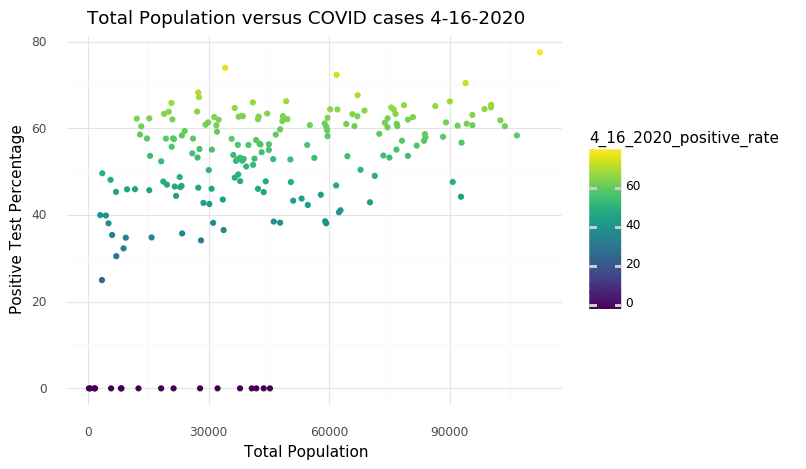

<ggplot: (311787097)>

In [18]:
(ggplot(ny, aes(x='tot_pop', y='4_16_2020_positive_rate', color= '4_16_2020_positive_rate'))+ geom_point()+theme_minimal()+ ggtitle("Total Population versus COVID cases 4-16-2020")+ xlab("Total Population")+ylab("Positive Test Percentage"))

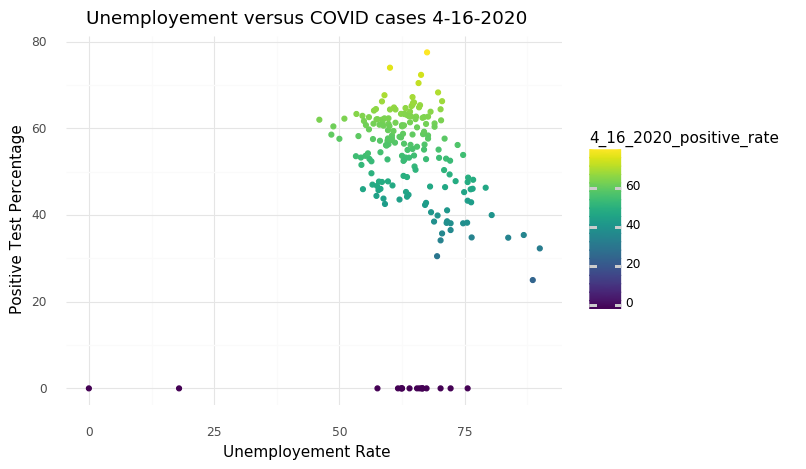

<ggplot: (311777657)>

In [19]:
(ggplot(ny, aes(x='unemployment_rate', y='4_16_2020_positive_rate', color= '4_16_2020_positive_rate'))+ geom_point()+theme_minimal()+ ggtitle("Unemployement versus COVID cases 4-16-2020")+ xlab("Unemployement Rate")+ylab("Positive Test Percentage"))

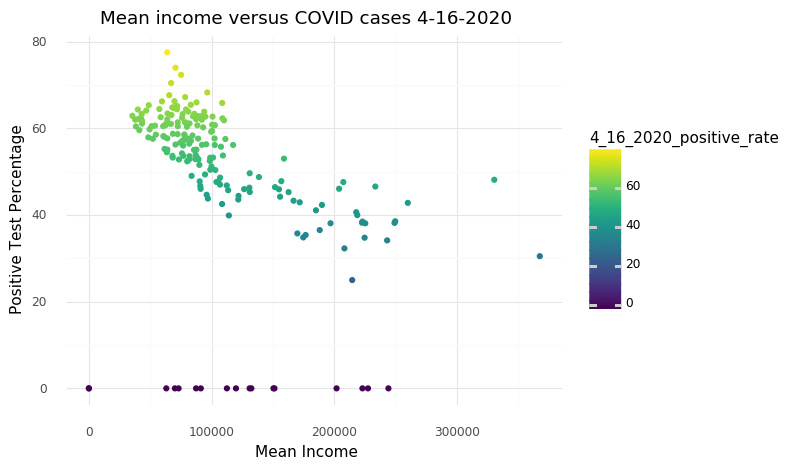

<ggplot: (312324529)>

In [20]:
(ggplot(ny, aes(x='mean_incom', y='4_16_2020_positive_rate', color= '4_16_2020_positive_rate'))+ geom_point()+theme_minimal()+ ggtitle("Mean income versus COVID cases 4-16-2020")+ xlab("Mean Income")+ylab("Positive Test Percentage"))

In [21]:
#creating a subset of the ny dataframe containing socio-economic variables
df = ny[['tot_pop','disabled', 'per_disabled', 'unemployment_rate','tot_households_snap','households_snap','per_households_snap','tot_pop_mobility','less_10k','10k_15k','15k_25k','25k_35k','35k_50k','50k_75k','75k_100k','100k_150k','150k_200k','more_200k','med_income','mean_incom','non_citizen','pop_pov','pop_below_','pcnt_pov','families_on_suplimental_income','families_on_social_security','insured','per_insured','uninsured','per_uninsured','owner','rent', '4_16_2020_positive_rate']].copy()

features = ['tot_pop','disabled', 'per_disabled', 'unemployment_rate','tot_households_snap','households_snap','per_households_snap','tot_pop_mobility','less_10k','10k_15k','15k_25k','25k_35k','35k_50k','50k_75k','75k_100k','100k_150k','150k_200k','more_200k','med_income','mean_incom','non_citizen','pop_pov','pop_below_','pcnt_pov','families_on_suplimental_income','families_on_social_security','insured','per_insured','uninsured','per_uninsured','owner','rent']

In [22]:
#standardize variables
zScore = StandardScaler() #standardize variables makes them easier with the math
zScore.fit(df[features])
df[features] = zScore.transform(df[features])

In [23]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors = 5, rotation=None)
fa.fit(df[features])

loadings = fa.loadings_

# Check Eigenvalues
ev, v =  fa.get_eigenvalues()

#create dataframe with relations between factors and variables
meaning = pd.DataFrame(loadings, columns = ['factor1', 'factor2','factor3','factor4','factor5'], index=features)
meaning

,factor1,factor2,factor3,factor4,factor5
tot_pop,0.836267,0.543765,0.031111,-0.023744,-0.044915
disabled,0.898024,0.256774,0.132348,0.159859,-0.089742
per_disabled,0.374822,-0.369962,-0.051127,0.396301,-0.167317
unemployment_rate,-0.319211,0.396844,0.212329,-0.059144,0.589986
tot_households_snap,0.732409,0.588941,0.184262,0.044988,-0.071236
households_snap,0.912059,-0.014669,0.280308,0.059714,0.045686
per_households_snap,0.830969,-0.394368,0.150628,0.123576,0.133156
tot_pop_mobility,0.835847,0.544910,0.029210,-0.023882,-0.045705
less_10k,0.680071,-0.368770,0.312668,0.136480,0.094291
10k_15k,0.740718,-0.421340,0.200697,0.284955,0.005535


In [24]:
# get the column name of max values in every row
maxValueIndexObj = meaning.idxmax(axis=1)
 
print("Max values of row are at following columns :")
print(maxValueIndexObj)

Max values of row are at following columns :
tot_pop                           factor1
disabled                          factor1
per_disabled                      factor4
unemployment_rate                 factor5
tot_households_snap               factor1
households_snap                   factor1
per_households_snap               factor1
tot_pop_mobility                  factor1
less_10k                          factor1
10k_15k                           factor1
15k_25k                           factor1
25k_35k                           factor1
35k_50k                           factor1
50k_75k                           factor1
75k_100k                          factor2
100k_150k                         factor2
150k_200k                         factor2
more_200k                         factor3
med_income                        factor2
mean_incom                        factor3
non_citizen                       factor1
pop_pov                           factor1
pop_below_                     

## 1 - Which variables go together using factor analysis?

From this analysis we can see the breakdown of each of the 5 factors and what the variables are that correspond to each. Factor 1 encompasses total population, disabled, total households snap, total population mobility, non_citizen, population in poverty, families on social security, insured, owner, and rent. Factor 2 encompasses primarily percent disabled, households snap, percent households snap, less than 10k, between 10k and 15k, between 12k and 25k, between 25k and 305k. Factor 3 is smaller than the others being primarily comprised of number of people between 35k and 50k, 50k and 75k, and 75k and 100k. Factor 4 is comprised of the higher incomes and mean and median incomes. Strangely, factor 5 is the highest value for only one variable and that is per_uninsured. 

In [25]:
xvals = range(1,df[features].shape[1]+1)

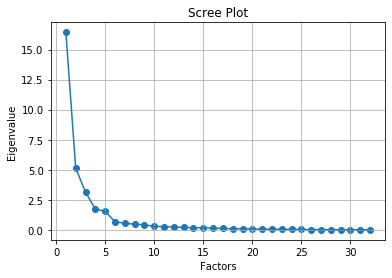

In [26]:
# Create scree plot using matplotlib
plt.scatter(xvals,ev)
plt.plot(xvals,ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [27]:
variance = fa.get_factor_variance()

vDF = pd.DataFrame(variance, columns = ['factor1', 'factor2','factor3','factor4','factor5'], index= ["SS Loadings", "Proportion Var", "Cumulative Var"])
vDF

,factor1,factor2,factor3,factor4,factor5
SS Loadings,16.310404,4.993170,2.925724,1.532068,1.315206
Proportion Var,0.509700,0.156037,0.091429,0.047877,0.041100
Cumulative Var,0.509700,0.665737,0.757166,0.805043,0.846143


In [28]:
X = df[features]
y = df["4_16_2020_positive_rate"]

In [29]:
model1 = LinearRegression()
model1.fit(X, y)
print("all data without train/test: ", model1.score(X, y))

all data without train/test:  0.5319451640160224


In [30]:
#kfold split
kf = KFold(n_splits = 5)
model2 = LinearRegression()
scores = []

for train, test in kf.split(X,y):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y[train]
    y_test = y[test]
    
    model2.fit(X_train,y_train)
    scores.append(model2.score(X_test,y_test))
    covid_pred = model2.predict(X_test)
    
print(scores)
print("mean all data score: ", np.mean(scores))

[-1.1439417235238252, 0.5767110159412059, -0.050248788580049775, -2.8646075370897357, -0.17382609197595356]
mean all data score:  -0.7311826250456717


In [31]:
true_v_pred= pd.DataFrame({"predict": covid_pred, "trueV": y_test})

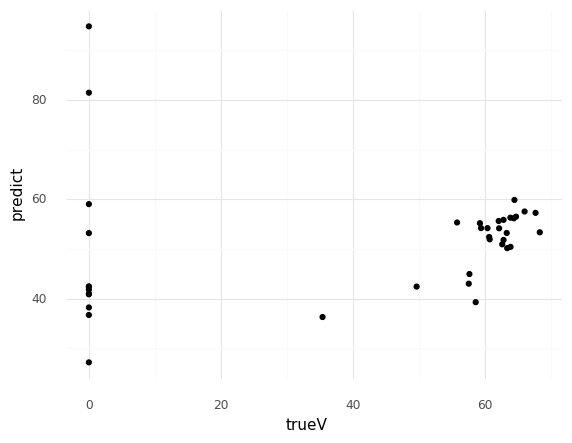

<ggplot: (312410889)>

In [32]:
ggplot(true_v_pred, aes(x = "trueV", y = "predict")) +geom_point() +theme_minimal()

In [33]:
#features = ['tot_pop','disabled', 'per_disabled', 'unemployment_rate','tot_households_snap','households_snap','per_households_snap','tot_pop_mobility','less_10k','10k_15k','15k_25k','25k_35k','35k_50k','50k_75k','75k_100k','100k_150k','150k_200k','more_200k','med_income','mean_incom','non_citizen','pop_pov','pop_below_','pcnt_pov','families_on_suplimental_income','families_on_social_security','insured','per_insured','uninsured','per_uninsured','owner','rent']

fact = fa.transform(df[features])
fact = pd.DataFrame(fact)

model3 = LinearRegression()
model3.fit(fact, df["4_16_2020_positive_rate"])
print("5 factors: ", model3.score(fact, df["4_16_2020_positive_rate"]))

5 factors:  0.39763750071372583


In [34]:
X = fact
y = df["4_16_2020_positive_rate"]

#kfold split
kf = KFold(n_splits = 5)
model4 = LinearRegression()
scores = []

for train, test in kf.split(X,y):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y[train]
    y_test = y[test]
    
    model4.fit(X_train,y_train)
    scores.append(model4.score(X_test,y_test))
    covid_pred = model4.predict(X_test)
    
print(scores)
print("mean all data score: ", np.mean(scores))

[-0.9732192165046517, 0.6489565459080127, 0.13676985759054394, -1.010477616671217, 0.10562510283839631]
mean all data score:  -0.21846906536778316


In [35]:
true_v_pred = pd.DataFrame({"predict": covid_pred, "trueV": y_test})

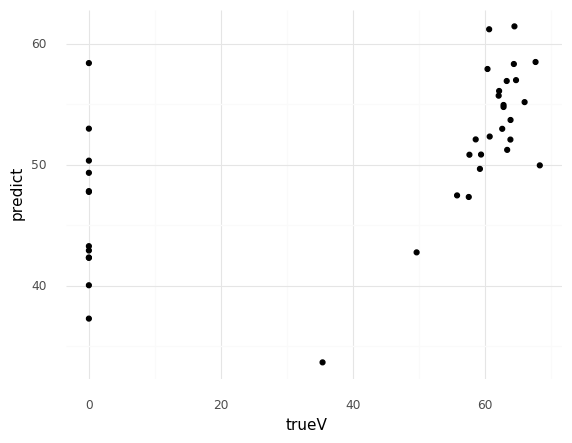

<ggplot: (315522013)>

In [36]:
ggplot(true_v_pred, aes(x = "trueV", y = "predict")) +geom_point() +theme_minimal()

## 2 - Which of these factors predict COVID cases?

The model with all 33 socio-economic variables fit with a linear model did not predict the number of COVID cases on 4/16/2020 that well. Without a train - test split it had an r2 score of roughly 0.5. We can see that the model was fitting to noise however because when a fit was performed using a train test split the model had a negative r2 score. This can happen if the regression line that the model predicts is worse than simply using the mean value, which is why r squared values are usually non-negative. 

The model with the 5 factored variables did not predict the COVID cases to any level os significance with an r2 score of 0.39 without using a kfold train test split. With a train test split the model had a score of -0.21.

From this analysis we know that there is some relationship between socio-economic variables and the number of COVID cases however, our model simply did not contain enough information to create an effective predictive model of COVID cases. 

We can see this visually from looking at the graphs from the last test split of predicted values versus true values. We would hope to see a clear diagonal line but see a large scattering of data points instead.


## Question: Does the strictness with which neighborhoods follow social distancing predict COVID cases?

## 3 - Did adherence to social distancing within boroughs affect covid rates 

In [37]:
import geopandas as gpd
import folium

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [38]:
ny_shp = gpd.read_file('data/spatial/bor_zip_codes.shp')

In [39]:
ny = pd.merge(ny_shp, ny, how='inner', left_on='GEOID10', right_on='GEOID_ZIP')
ny.crs= {'init': 'epsg:4326'} #WGS84

In [40]:
map = folium.Map(location=[40.692416, -74.025393],zoom_start=10)
poly = ny.to_crs(epsg=4326).to_json()
geom = folium.features.GeoJson(poly)
map.add_child(geom)
map

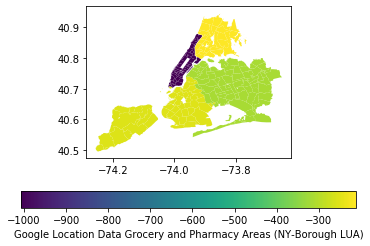

In [41]:
fig, ax = plt.subplots(1, 1)

ny.plot(column='grocery_and_pharmacy_percent_change_from_baseline_sum',
        ax=ax,
        legend=True,
        legend_kwds={'label': "Google Location Data Grocery and Pharmacy Areas (NY-Borough LUA)",
        'orientation': "horizontal"})
plt.show()

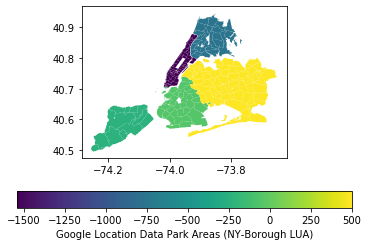

In [42]:
fig, ax = plt.subplots(1, 1)

ny.plot(column='parks_percent_change_from_baseline_sum',
        ax=ax,
        legend=True,
        legend_kwds={'label': "Google Location Data Park Areas (NY-Borough LUA)",
        'orientation': "horizontal"})
plt.show()

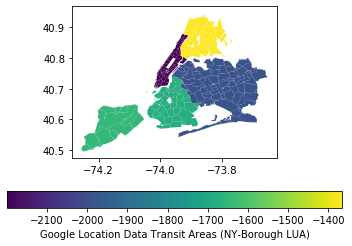

In [43]:
fig, ax = plt.subplots(1, 1)

ny.plot(column='transit_stations_percent_change_from_baseline_sum',
        ax=ax,
        legend=True,
        legend_kwds={'label': "Google Location Data Transit Areas (NY-Borough LUA)",
        'orientation': "horizontal"})
plt.show()

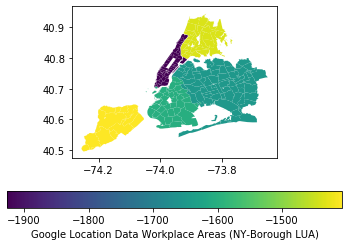

In [44]:
fig, ax = plt.subplots(1, 1)

ny.plot(column='workplaces_percent_change_from_baseline_sum',
        ax=ax,
        legend=True,
        legend_kwds={'label': "Google Location Data Workplace Areas (NY-Borough LUA)",
        'orientation': "horizontal"})
plt.show()

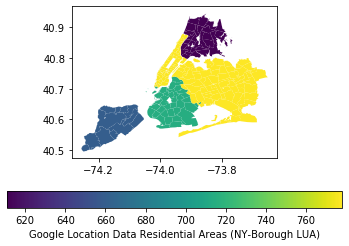

In [45]:
fig, ax = plt.subplots(1, 1)

ny.plot(column='residential_percent_change_from_baseline_sum',
        ax=ax,
        legend=True,
        legend_kwds={'label': "Google Location Data Residential Areas (NY-Borough LUA)",
        'orientation': "horizontal"})
plt.show()

In [46]:
predictors = ["grocery_and_pharmacy_percent_change_from_baseline_sum", "parks_percent_change_from_baseline_sum", "transit_stations_percent_change_from_baseline_sum", "workplaces_percent_change_from_baseline_sum", "residential_percent_change_from_baseline_sum"]

# Not standardizing because vars are on the same scale
X_train, X_test, y_train, y_test = train_test_split(ny[predictors], ny["4_16_2020_positive"], test_size=0.2,random_state=123)

In [47]:
mod = sm.OLS(y_train,X_train)
fit = mod.fit()

In [47]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     4_16_2020_positive   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     9.840
Date:                Mon, 18 May 2020   Prob (F-statistic):           4.26e-07
Time:                        16:58:20   Log-Likelihood:                -1162.7
No. Observations:                 155   AIC:                             2335.
Df Residuals:                     150   BIC:                             2351.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
grocery_and_pharmacy_percent_change_from_baseline_sum    -0.1878      3.876     -0.048      0.961      -7.847       7.471
parks_percent_change_from_baseline_sum                   -0.4909      0.224     -2.188      0.030      -0.934      -0.048
transit_stations_percent_change_from_baseline_sum         2.2182      4.842      0.458      0.648      -7.349      11.785
workplaces_percent_change_from_baseline_sum               2.9630      5.505      0.538      0.591      -7.914      13.840
residential_percent_change_from_baseline_sum             12.8128     22.155      0.578      0.564     -30.963      56.589
==============================================================================
Omnibus:                       45.945   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.431
Skew:                           1.174   Prob(JB):                     2.13e-28
Kurtosis:                       6.771   Cond. No.                     1.77e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
test_preds = fit.predict(X_test)

In [49]:
true_v_pred = pd.DataFrame({"predict": test_preds, "trueV": y_test})

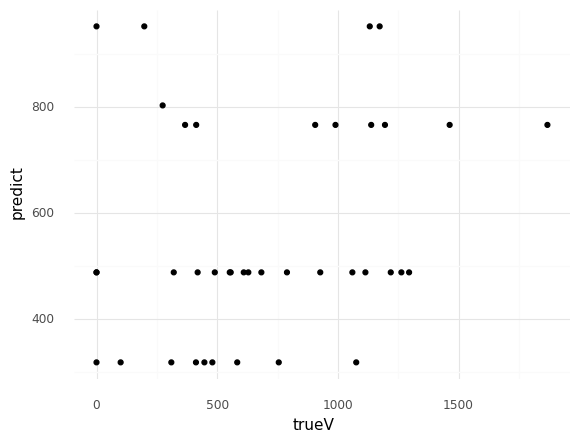

<ggplot: (-9223371899286218784)>

In [50]:
ggplot(true_v_pred, aes(x = "trueV", y = "predict")) +geom_point() +theme_minimal()

In [51]:
print('testing r2 is:', r2_score(test_preds, y_test))

testing r2 is: -4.2873808705790095


In [52]:
#creating a subset of the ny dataframe containing socio-economic variables
df = ny[['tot_pop','disabled', 'per_disabled', 'unemployment_rate','tot_households_snap','households_snap','per_households_snap','tot_pop_mobility','less_10k','10k_15k','15k_25k','25k_35k','35k_50k','50k_75k','75k_100k','100k_150k','150k_200k','more_200k','med_income','mean_incom','non_citizen','pop_pov','pop_below_','pcnt_pov','families_on_suplimental_income','families_on_social_security','insured','per_insured','uninsured','per_uninsured','owner','rent', '4_16_2020_positive_rate', "grocery_and_pharmacy_percent_change_from_baseline_sum", "parks_percent_change_from_baseline_sum", "transit_stations_percent_change_from_baseline_sum", "workplaces_percent_change_from_baseline_sum", "residential_percent_change_from_baseline_sum"]].copy()

features = ['tot_pop','disabled', 'per_disabled', 'unemployment_rate','tot_households_snap','households_snap','per_households_snap','tot_pop_mobility','less_10k','10k_15k','15k_25k','25k_35k','35k_50k','50k_75k','75k_100k','100k_150k','150k_200k','more_200k','med_income','mean_incom','non_citizen','pop_pov','pop_below_','pcnt_pov','families_on_suplimental_income','families_on_social_security','insured','per_insured','uninsured','per_uninsured','owner','rent',"grocery_and_pharmacy_percent_change_from_baseline_sum", "parks_percent_change_from_baseline_sum", "transit_stations_percent_change_from_baseline_sum", "workplaces_percent_change_from_baseline_sum", "residential_percent_change_from_baseline_sum"]

In [53]:
#standardize variables
zScore = StandardScaler() #standardize variables makes them easier with the math
zScore.fit(df[features])
df[features] = zScore.transform(df[features])

In [54]:
predictors = ['tot_pop','disabled', 'per_disabled', 'unemployment_rate','tot_households_snap','households_snap','per_households_snap','tot_pop_mobility','less_10k','10k_15k','15k_25k','25k_35k','35k_50k','50k_75k','75k_100k','100k_150k','150k_200k','more_200k','med_income','mean_incom','non_citizen','pop_pov','pop_below_','pcnt_pov','families_on_suplimental_income','families_on_social_security','insured','per_insured','uninsured','per_uninsured','owner','rent',"grocery_and_pharmacy_percent_change_from_baseline_sum", "parks_percent_change_from_baseline_sum", "transit_stations_percent_change_from_baseline_sum", "workplaces_percent_change_from_baseline_sum", "residential_percent_change_from_baseline_sum"]

# Not standardizing because vars are on the same scale
X_train, X_test, y_train, y_test = train_test_split(ny[predictors], ny["4_16_2020_positive"], test_size=0.2,random_state=123)

In [55]:
mod = sm.OLS(y_train,X_train)
fit = mod.fit()

In [56]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     4_16_2020_positive   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     23.94
Date:                Mon, 18 May 2020   Prob (F-statistic):           4.27e-39
Time:                        16:58:21   Log-Likelihood:                -1021.8
No. Observations:                 155   AIC:                             2114.
Df Residuals:                     120   BIC:                             2220.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
tot_pop                                                   0.1578      0.115      1.369      0.174      -0.071       0.386
disabled                                                  0.0706      0.032      2.218      0.028       0.008       0.134
per_disabled                                             -3.2202     11.848     -0.272      0.786     -26.678      20.237
unemployment_rate                                        11.4882      5.528      2.078      0.040       0.543      22.434
tot_households_snap                                      -0.0210      0.010     -2.182      0.031      -0.040      -0.002
households_snap                                          -0.0254      0.047     -0.543      0.588      -0.118       0.067
per_households_snap                                      -5.0388      7.821     -0.644      0.521     -20.524      10.447
tot_pop_mobility                                         -0.0297      0.114     -0.260      0.795      -0.256       0.197
less_10k                                                 14.8453     12.485      1.189      0.237      -9.873      39.564
10k_15k                                                  15.0613     14.126      1.066      0.288     -12.908      43.030
15k_25k                                                   4.4207     12.975      0.341      0.734     -21.268      30.110
25k_35k                                                  -0.3622     13.675     -0.026      0.979     -27.438      26.713
35k_50k                                                  14.2725     11.519      1.239      0.218      -8.535      37.080
50k_75k                                                  -3.2912     10.332     -0.319      0.751     -23.748      17.166
75k_100k                                                 -3.7376     11.064     -0.338      0.736     -25.643      18.168
100k_150k                                                -6.8432      8.286     -0.826      0.411     -23.249       9.563
150k_200k                                               -24.2118     13.627     -1.777      0.078     -51.193       2.770
more_200k                                                -9.8542     10.093     -0.976      0.331     -29.838      10.129
med_income                                                0.0007      0.001      0.492      0.623      -0.002       0.003
mean_incom                                                0.0009      0.002      0.454      0.651      -0.003       0.005
non_citizen                                               0.0088      0.011      0.803      0.423      -0.013       0.030
pop_pov                                                   0.0254      0.020      1.256      0.212      -0.015       0.065
pop_below_                       

In [57]:
test_preds = fit.predict(X_test)

In [58]:
true_v_pred = pd.DataFrame({"predict": test_preds, "trueV": y_test})

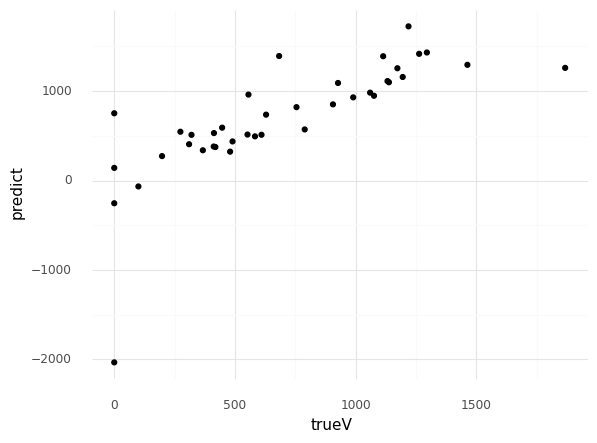

<ggplot: (-9223371899286163844)>

In [59]:
ggplot(true_v_pred, aes(x = "trueV", y = "predict")) +geom_point() +theme_minimal()

In [60]:
print('testing r2 is:', r2_score(test_preds, y_test))

testing r2 is: 0.5706548247618044


## 3 - Did adherence to social distancing within boroughs affect covid rates 

Given the generalized google location tracking data we have, there is unclear results as to exactly how our social distancing metric affected our model. Some variables resulted in having a negative relationship with covid positive results as we had thought, we see this with the negative coefficient values in transit, parks, and residential areas. However positive relationships in grocery, pharmacy, and workplace areas. All in all though, we see p values > .05 signaling that although we have coeficient magnitude estimate, they are not statistically significant, this is likely due to the fact that the location data we have is set to the borough level unit of analysis and not the zipcode level. 


Overall we do believe that social distancing has reduced covid transmission within communities, however we cannot confidently estimate figures detailing how much it has helped.

## Question: What does a disadvantaged group look like in terms of COVID cases?


## 4 - Would a clustering model help us group zipcodes together

## 5 - How well do these clustered groups predict COVID


In [59]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

In [62]:
features = ['per_female','per_male','less_10k', '10k_15k', '15k_25k',
       '25k_35k', '35k_50k', '50k_75k', '75k_100k', '100k_150k',
       '150k_200k', 'more_200k', 'med_income', 'mean_incom','pcnt_pov', 'families_on_suplimental_income',
       'families_on_social_security', 'per_white', 'per_black', 'per_native',
       'per_asian', 'per_hawaiian', 'per_other', 'per_two_or']

In [63]:
X = ny[features]

In [64]:
z = StandardScaler()
X[features] = z.fit_transform(X)

In [65]:
n_components = [3,4,5,6,7,8,9,10]
Xdf = X

In [66]:
sils = []

for n in n_components:
    gmm = GaussianMixture(n_components = n)
    gmm.fit(X)
    colName = str(n) + "GM_assign"
    clusters = gmm.predict(X)
    
    Xdf[colName] = clusters
    
    sils.append(silhouette_score(X, clusters))
    
print(sils)

[0.2466641024368184, 0.2053848264614691, 0.23376305330607947, 0.25964942354987824, 0.33341662457102605, 0.3670747242833877, 0.3999786456035729, 0.4425383671411636]


In [67]:
sils = []

for n in n_components:
    hac = AgglomerativeClustering(n_clusters = n,
                              affinity = "euclidean",
                             linkage = "ward")
    hac.fit(X)
    
    colName = str(n) + "HAC_assign"
    clusters = hac.labels_
    
    Xdf[colName] = clusters
    
    sils.append(silhouette_score(X, clusters))
    
print(sils)

[0.3215461872534769, 0.40370529520669696, 0.4291383432594554, 0.4721264136978748, 0.48007262235813, 0.5354309788542874, 0.5493113887417092, 0.5715371039307389]


In [68]:
sils = []

for n in n_components:
    km = KMeans(n_clusters = n)
    km.fit(X)
    colName = str(n) + "KM_assign"
    clusters = km.predict(X)
    
    Xdf[colName] = clusters
    
    sils.append(silhouette_score(X, clusters))
    
print(sils)

[0.3459980344601063, 0.4337730672176859, 0.4865087418057556, 0.5230348508178829, 0.571312647022294, 0.6154559450283918, 0.6425154980247509, 0.6586907648445711]


In [69]:
groups = ['5GM_assign', '5KM_assign', '5HAC_assign','9GM_assign', '9KM_assign', '9HAC_assign', 'index']

In [70]:
ny.reset_index(inplace = True)
Xdf.reset_index(inplace = True)

In [71]:
ny_clusters = pd.merge(ny,Xdf[groups], on='index')

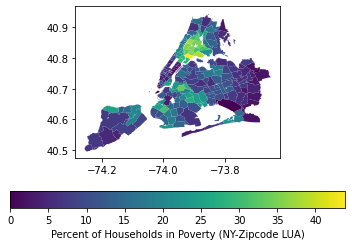

In [72]:
fig, ax = plt.subplots(1, 1)

ny.plot(column='pcnt_pov',
        ax=ax,
        legend=True,
        legend_kwds={'label': "Percent of Households in Poverty (NY-Zipcode LUA)",
        'orientation': "horizontal"})
plt.show()

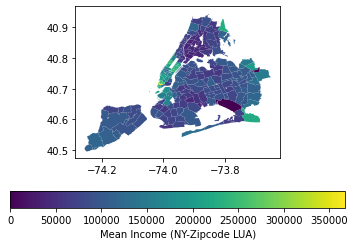

In [76]:
fig, ax = plt.subplots(1, 1)

ny.plot(column='mean_incom',
        ax=ax,
        legend=True,
        legend_kwds={'label': "Mean Income (NY-Zipcode LUA)",
        'orientation': "horizontal"})
plt.show()

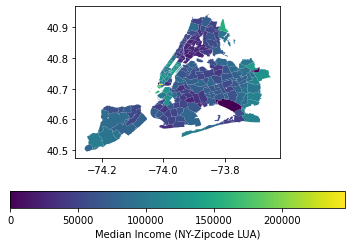

In [74]:
fig, ax = plt.subplots(1, 1)

ny.plot(column='med_income',
        ax=ax,
        legend=True,
        legend_kwds={'label': "Median Income (NY-Zipcode LUA)",
        'orientation': "horizontal"})
plt.show()

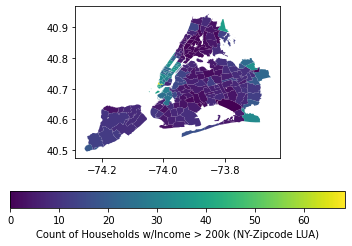

In [77]:
fig, ax = plt.subplots(1, 1)

ny.plot(column='more_200k',
        ax=ax,
        legend=True,
        legend_kwds={'label': "Count of Households w/Income > 200k (NY-Zipcode LUA)",
        'orientation': "horizontal"})
plt.show()

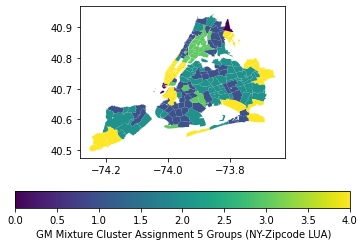

In [73]:
fig, ax = plt.subplots(1, 1)

ny_clusters.plot(column='5GM_assign',
        ax=ax,
        legend=True,
        legend_kwds={'label': " GM Mixture Cluster Assignment 5 Groups (NY-Zipcode LUA)",
        'orientation': "horizontal"})
plt.show()

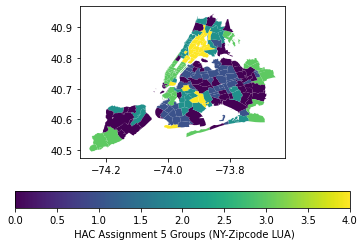

In [75]:
fig, ax = plt.subplots(1, 1)

ny_clusters.plot(column='5HAC_assign',
        ax=ax,
        legend=True,
        legend_kwds={'label': " HAC Assignment 5 Groups (NY-Zipcode LUA)",
        'orientation': "horizontal"})
plt.show()

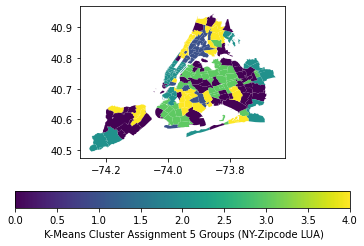

In [78]:
fig, ax = plt.subplots(1, 1)

ny_clusters.plot(column='5KM_assign',
        ax=ax,
        legend=True,
        legend_kwds={'label': " K-Means Cluster Assignment 5 Groups (NY-Zipcode LUA)",
        'orientation': "horizontal"})
plt.show()

### Elmer, would we be able to take this out? Usually you wouldn't perform ols on clusters

In [79]:
predictors = ['9GM_assign', '9KM_assign', '9HAC_assign']

X_train, X_test, y_train, y_test = train_test_split(ny_clusters[predictors], ny_clusters["4_16_2020_positive"], test_size=0.2)

In [80]:
mod = sm.OLS(y_train,X_train)
fit = mod.fit()

In [81]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     4_16_2020_positive   R-squared (uncentered):                   0.619
Model:                            OLS   Adj. R-squared (uncentered):              0.611
Method:                 Least Squares   F-statistic:                              82.19
Date:                Mon, 18 May 2020   Prob (F-statistic):                    1.19e-31
Time:                        16:58:30   Log-Likelihood:                         -1176.9
No. Observations:                 155   AIC:                                      2360.
Df Residuals:                     152   BIC:                                      2369.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
9GM_assign     66.5910     21.923      3.038      0.003      23.278     109.904
9KM_assign    111.3045     18.250      6.099      0.000      75.249     147.360
9HAC_assign   -29.8750     19.173     -1.558      0.121     -67.754       8.004
==============================================================================
Omnibus:                       16.156   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.506
Skew:                           0.648   Prob(JB):                     3.53e-05
Kurtosis:                       4.224   Cond. No.                         4.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
test_preds = fit.predict(X_test)

In [83]:
true_v_pred = pd.DataFrame({"predict": test_preds, "trueV": y_test})

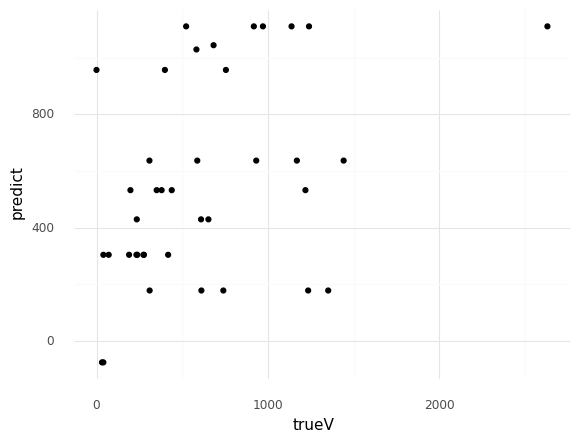

<ggplot: (-9223371899286597548)>

In [84]:
ggplot(true_v_pred, aes(x = "trueV", y = "predict")) +geom_point() +theme_minimal()

In [85]:
print('testing r2 is:', r2_score(test_preds, y_test))

testing r2 is: -0.9258186456384181


In [94]:
features = ['per_female','per_male','less_10k', '10k_15k', '15k_25k',
       '25k_35k', '35k_50k', '50k_75k', '75k_100k', '100k_150k',
       '150k_200k', 'more_200k', 'med_income', 'mean_incom','pcnt_pov', 'families_on_suplimental_income',
       'families_on_social_security', 'per_white', 'per_black', 'per_native',
       'per_asian', 'per_hawaiian', 'per_other', 'per_two_or']

X = ny[features]
y = ny["per_infected"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

z = StandardScaler()
X_train = z.fit_transform(X_train)
X_test = z.transform(X_test)

params = {'n_neighbors': range(1,30)}

knn = neighbors.KNeighborsRegressor()

grid = GridSearchCV(knn, params, cv=5)

knnmod = grid.fit(X_train, y_train)

In [95]:
knnmod.best_estimator_.get_params()["n_neighbors"]

6

In [96]:
knnmod.best_score_

0.3609291699194562

In [97]:
knnmod.score(X_test,y_test)

0.12485298364806131

## 4 - Would a clustering model help us group zipcodes together

We were unable to intuitively determine what unsupervised clustering method would perform the best and create the most distinct clusters determined by silhouette score. We performed 3 clustering models to compare which performed best. The models we chose were Hierarchical Agglomerative Clustering, Gaussian Mixture Modeling, and Kmeans. The clustering models were able to help us group zipcodes together based on gender, financial, and minority composition. In creating the models, we were cautious to avoid overfitting the data by using too many clusters to we capped the number of clusters that we tested for HAC, GMM, and Kmeans at 9. From 3-9 clusters, we selected 5 clusters and 9 clusters to analyze more in depth with each of the 3 models. We did this both graphically and analytically by looking at their silhouette score. The model that performed the best was Kmeans followed by HAC and GMM. Unfortunately, there is still a possibility that as we increased the number of clusters that the silhouette score would have also increased but this is perhaps not representative of our data. It simply means that we are creating more clusters so they will be more distict thereby creating a better silhouette score. We would need to spend more time analyzing the clusters to determine what number of clusters would most logically make sense. We will be passing along the cluster data created from the models to another reasearcher who is a part of the Community Health Equity Lab and is experienced at determining the relationships and commonalities in the large variety of variables that we have. We hope that this anaylsis is useful in determining what commonalities exist between certain zipcodes.

## 5 - How well do clustered groups predict COVID

Using a KNN regressor model we used clustering to predict covid cases. The clustering method did not prove to predict covid cases well to any level of signigicance. A grid search selected 6 as the ideal number of neighbors. The model's best score was 0.36 and the score of the test set was 0.12. We do not know if the model itself was too simple to predict the number of covid cases or if the data that we have available is simply not significant enough to achieve a high prediction score.

## Question: Are beds being allocated to areas most affected by covid?


## 6 - What variables contribute to allocation of resources


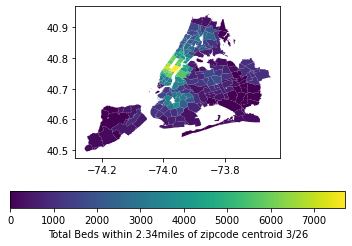

In [86]:
fig, ax = plt.subplots(1, 1)

ny.plot(column='3_26_bb_beds',
        ax=ax,
        legend=True,
        legend_kwds={'label': "Total Beds within 2.34miles of zipcode centroid 3/26",
        'orientation': "horizontal"})
plt.show()

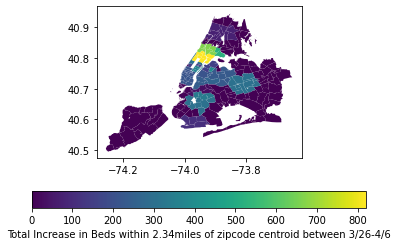

In [87]:
fig, ax = plt.subplots(1, 1)

ny.plot(column='change_in_bed',
        ax=ax,
        legend=True,
        legend_kwds={'label': "Total Increase in Beds within 2.34miles of zipcode centroid between 3/26-4/6",
        'orientation': "horizontal"})
plt.show()

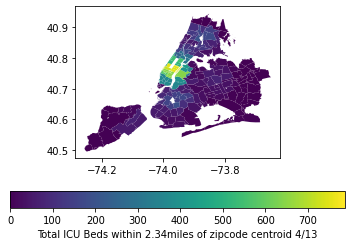

In [88]:
fig, ax = plt.subplots(1, 1)

ny.plot(column='ICU_beds',
        ax=ax,
        legend=True,
        legend_kwds={'label': "Total ICU Beds within 2.34miles of zipcode centroid 4/13",
        'orientation': "horizontal"})
plt.show()

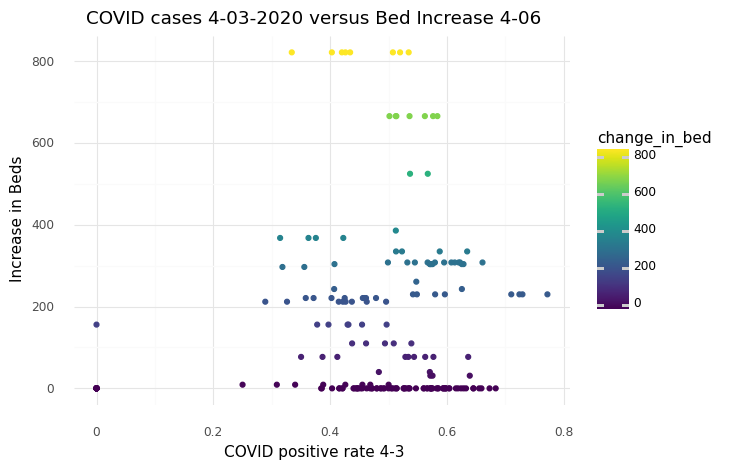

<ggplot: (-9223371899284533860)>

In [89]:
(ggplot(ny, aes(x='4_3_2020_positive_rate', y='change_in_bed', color= 'change_in_bed'))+ geom_point()+theme_minimal()+ ggtitle("COVID cases 4-03-2020 versus Bed Increase 4-06")+ xlab("COVID positive rate 4-3")+ylab("Increase in Beds"))

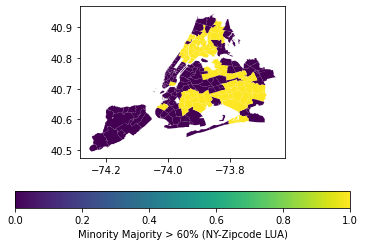

In [90]:
fig, ax = plt.subplots(1, 1)

ny.plot(column='minority-majority-60',
        ax=ax,
        legend=True,
        legend_kwds={'label': "Minority Majority > 60% (NY-Zipcode LUA)",
        'orientation': "horizontal"})
plt.show()

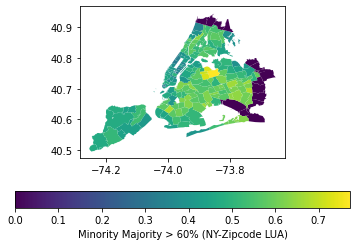

In [91]:
fig, ax = plt.subplots(1, 1)

ny.plot(column='4_3_2020_positive_rate',
        ax=ax,
        legend=True,
        legend_kwds={'label': "Minority Majority > 60% (NY-Zipcode LUA)",
        'orientation': "horizontal"})
plt.show()

In [222]:
#creating a subset of the ny dataframe containing socio-economic variables
df = ny[['per_disabled', 'unemployment_rate','per_households_snap','less_10k','10k_15k','15k_25k','25k_35k','35k_50k','50k_75k','75k_100k','100k_150k','150k_200k','more_200k','med_income','mean_incom','non_citizen','pcnt_pov','families_on_suplimental_income','families_on_social_security','per_insured','owner','rent',"minority-majority-50", "4_3_2020_positive_rate",'change_in_bed']
].copy()

features = ['per_disabled', 'unemployment_rate','per_households_snap','less_10k','10k_15k','15k_25k','25k_35k','35k_50k','50k_75k','75k_100k','100k_150k','150k_200k','more_200k','med_income','mean_incom','non_citizen','pcnt_pov','families_on_suplimental_income','families_on_social_security','per_insured','owner','rent',"minority-majority-50", "4_3_2020_positive_rate"]

In [223]:
#standardize variables

zScore = StandardScaler() #standardize variables makes them easier with the math
zScore.fit(df[features])
df[features] = zScore.transform(df[features])

In [224]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df["change_in_bed"], test_size=0.2,random_state=123)

In [225]:
mod = sm.OLS(y_train,X_train)
fit = mod.fit()

In [226]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          change_in_bed   R-squared (uncentered):                   0.272
Model:                            OLS   Adj. R-squared (uncentered):              0.138
Method:                 Least Squares   F-statistic:                              2.037
Date:                Mon, 18 May 2020   Prob (F-statistic):                     0.00602
Time:                        17:47:13   Log-Likelihood:                         -1055.1
No. Observations:                 155   AIC:                                      2158.
Df Residuals:                     131   BIC:                                      2231.
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
per_disabled                       4.9207     45.996      0.107      0.915     -86.070      95.912
unemployment_rate                105.4346     47.518      2.219      0.028      11.432     199.437
per_households_snap             -144.1985     83.574     -1.725      0.087    -309.527      21.130
less_10k                         122.5094     57.244      2.140      0.034       9.267     235.751
10k_15k                          113.9009     55.860      2.039      0.043       3.397     224.405
15k_25k                            5.9978     56.487      0.106      0.916    -105.747     117.743
25k_35k                           17.5012     44.729      0.391      0.696     -70.984     105.986
35k_50k                            3.3643     46.247      0.073      0.942     -88.123      94.851
50k_75k                           -7.2284     44.643     -0.162      0.872     -95.542      81.085
75k_100k                         -45.7765     36.633     -1.250      0.214    -118.245      26.692
100k_150k                         51.2340     46.552      1.101      0.273     -40.858     143.326
150k_200k                        -41.3604     58.125     -0.712      0.478    -156.346      73.625
more_200k                       -262.7719    140.013     -1.877      0.063    -539.752      14.208
med_income                       -19.5878     55.588     -0.352      0.725    -129.555      90.379
mean_incom                       215.2056    126.268      1.704      0.091     -34.583     464.994
non_citizen                       97.5429     50.723      1.923      0.057      -2.799     197.884
pcnt_pov                          41.0190     90.440      0.454      0.651    -137.893     219.931
families_on_suplimental_income   -97.9964     72.027     -1.361      0.176    -240.483      44.490
families_on_social_security      -13.8095     74.311     -0.186      0.853    -160.814     133.195
per_insured                      205.1401     96.365      2.129      0.035      14.506     395.774
owner                             -4.7470     54.246     -0.088      0.930    -112.058     102.564
rent                              29.1182     48.853      0.596      0.552     -67.524     125.761
minority-majority-50              34.4424     27.626      1.247      0.215     -20.209      89.093
4_3_2020_positive_rate           -10.4909     25.982     -0.404      0.687     -61.890      40.908
==============================================================================
Omnibus:                       12.745   Durbin-Watson:                   1.379
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.072
Skew:                           0.602   Prob(JB):                     0.00

In [227]:
test_preds = fit.predict(X_test)

In [228]:
true_v_pred = pd.DataFrame({"predict": test_preds, "trueV": y_test})

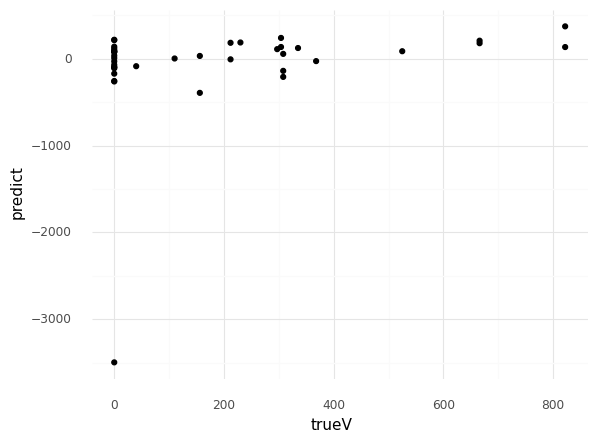

<ggplot: (-9223371899286447160)>

In [229]:
ggplot(true_v_pred, aes(x = "trueV", y = "predict")) +geom_point() +theme_minimal()

In [230]:
print('testing r2 is:', r2_score(test_preds, y_test))

testing r2 is: -0.15185170223281252


## 6 - What variables contribute to allocation of resources

Although poor R2 and pvalues, variables that seem to have the strongest positive relationships with bed allocations are percentage of zipcodes with insurance, mean income, and count of households that make between 10k and 15k

variables that seem to have the strongest negative relationships with bed allocations are  count of households that make between >200k, percentage of zipcodes with households on foodstamps, and percentage of zipcodes with households on supplemental income.